##### Import

In [1]:
import warnings
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from tqdm import tqdm
import shap
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
import os
import gc
import sys

# Filter out warning messages
warnings.filterwarnings('ignore')

# Set pandas display options
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

# Set seaborn style
sns.set_style('whitegrid')

# Add the parent directory to sys.path
sys.path.insert(1, os.path.join(sys.path[0], '..'))

# Index and deciles for data slicing
idx = pd.IndexSlice

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
import pandas as pd
from pathlib import Path

DATA_STORE = Path('data/250_dataset.h5')

with pd.HDFStore(DATA_STORE) as store:
    keys = store.keys()

print(keys)

['/data/YEAR_20130102_20141208', '/data/YEAR_20141209_20161114', '/data/YEAR_20161115_20181022', '/data/YEAR_20181023_20200928', '/data/YEAR_20200929_20220902', '/data/YEAR_20220906_20230811', '/data/ic_based_reduced_features_YEAR_20130102_20141208', '/data/ic_based_reduced_features_YEAR_20141209_20161114', '/data/ic_based_reduced_features_YEAR_20161115_20181022', '/data/ic_based_reduced_features_YEAR_20181023_20200928', '/data/ic_based_reduced_features_YEAR_20200929_20220902', '/data/ic_based_reduced_features_YEAR_20220906_20230811']


In [3]:
from utils import rank_and_quantize

with pd.HDFStore(DATA_STORE) as store:
    # dataset = store['/data/YEAR_20220906_20230811']
    dataset = store['/data/YEAR_20161115_20181022']
    dataset = rank_and_quantize(dataset, TARGET_col='TARGET_ret_fwd_frac_order')

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 123208 entries, ('AA', Timestamp('2016-11-15 00:00:00')) to ('ZTS', Timestamp('2018-10-22 00:00:00'))
Columns: 600 entries, FEATURE_open to TARGET_ret_fwd_frac_order_quantiled
dtypes: float32(360), float64(32), int32(198), int64(1), int8(9)
memory usage: 294.8+ MB


In [5]:
# Assuming your DataFrame is named df
cols = dataset.columns.tolist()

# Populate the features list with column names starting with 'feature_'
features = [col for col in cols if col.startswith('FEATURE_')]

# Find the first column starting with 'target_' and set it as the label
label_cols = [col for col in cols if col.startswith('TARGET_')]
# print(label_cols)
# label = label_cols[0] if label_cols else None
label = 'TARGET_ret_fwd_frac_order_quantiled'
print(len(features))  # This will show all the columns starting with 'feature_'
print(label)  # This will show the first column starting with 'target_'

586
TARGET_ret_fwd_frac_order_quantiled


In [6]:
# Get unique dates and sort them
unique_dates = dataset.index.get_level_values('date').unique().sort_values()

# Adjust for the look-ahead gap
look_ahead = 1

# Split dates for training and testing with a gap
train_dates = unique_dates[:-21-look_ahead]
test_dates = unique_dates[-21:]

# Split the dataset
train_data = dataset.loc[pd.IndexSlice[:, train_dates], :]
test_data = dataset.loc[pd.IndexSlice[:, test_dates], :]

In [7]:
def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                index=model.feature_name()))
                
def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True
    return 'ic', spearmanr(preds, train_data.get_label())[0], \
        is_higher_better

In [8]:
def sharpe_ratio_lgbm(preds, train_data):
    """Custom Sharpe ratio eval metric for lightgbm that calculates daily Spearman correlations."""
    labels = train_data.get_label()
    
    # Assuming the data index is a MultiIndex with date as the first level
    if not isinstance(train_data.data.index, pd.MultiIndex):
        raise ValueError("Expecting a MultiIndex with date as the first level")

    # Group by the first level of the MultiIndex (date) and compute the Spearman correlation for each group
    grouped_labels = pd.Series(labels, \
        index=train_data.data.index).groupby(level=0)
    # print(len(grouped_labels))
    grouped_preds = pd.Series(preds, \
        index=train_data.data.index).groupby(level=0)
    # print(len(grouped_preds))

    daily_scores = []
    for (_, actuals_for_day), (_, preds_for_day) in zip(grouped_labels, grouped_preds):
        score_for_day = spearmanr(actuals_for_day, preds_for_day)[0]
        if np.isnan(score_for_day):
            score_for_day = 0
        daily_scores.append(score_for_day)

    # Calculate the Sharpe ratio
    sharpe_ratio = np.mean(daily_scores) / (np.std(daily_scores) + 1e-9)  # added epsilon to avoid division by zero

    return 'sharpe_ratio', sharpe_ratio, True

In [9]:
def metrics_on_fold(era_scores):
    era_scores = pd.Series(era_scores)
    
    # Calculate metrics
    mean_correlation = np.mean(era_scores)
    std_deviation = np.std(era_scores)
    sharpe_ratio = mean_correlation / std_deviation
    max_dd = (era_scores.cummax() - era_scores).max()

    # Smart Sharpe
    smart_sharpe = mean_correlation / (std_deviation + np.std(era_scores.diff()))
    
    # Autocorrelation
    autocorrelation = era_scores.autocorr()

    metrics = pd.Series({
        'mean_correlation': mean_correlation,
        'std_deviation': std_deviation,
        'sharpe_ratio': sharpe_ratio,
        'smart_sharpe': smart_sharpe,
        'autocorrelation': autocorrelation,
        'max_dd': max_dd,
        'min_correlation': era_scores.min(),
        'max_correlation': era_scores.max(),
    })

    # Cleanup
    _ = gc.collect()
    
    return metrics

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 117642 entries, ('AA', Timestamp('2016-11-15 00:00:00')) to ('ZTS', Timestamp('2018-09-20 00:00:00'))
Columns: 600 entries, FEATURE_open to TARGET_ret_fwd_frac_order_quantiled
dtypes: float32(360), float64(32), int32(198), int64(1), int8(9)
memory usage: 281.5+ MB


In [11]:
## DONT DELETE or MODIFY
import numpy as np
import pandas as pd
import lightgbm as lgb
import optuna
from optuna.integration import LightGBMPruningCallback
from scipy.stats import spearmanr
from utils import CustomBackwardMultipleTimeSeriesCV

warnings.filterwarnings('ignore')


evals_result = {}

def objective(trial, data, features, categoricals, cv):
    params = {
        'boosting': 'gbdt',
        'objective': 'regression',
        'verbose': -1,
        'metric': 'None',
        'device': 'gpu',
        'num_leaves': trial.suggest_int('num_leaves', 30, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
    }

    # Create a LightGBM callback for early stopping
    early_stopping = lgb.early_stopping(stopping_rounds=500, \
        verbose=True, first_metric_only=True)

    all_daily_scores = []
    # print(cv)
    for train_idx, val_idx in cv:
        train_features = data.loc[train_idx, features]
        train_labels = data.loc[train_idx, label]

        lgb_train = lgb.Dataset(data=train_features, label=train_labels, 
                                categorical_feature=categoricals,
                                free_raw_data=False)

        val_features = data.loc[val_idx, features]
        val_labels = data.loc[val_idx, label]

        lgb_val = lgb.Dataset(data=val_features, label=val_labels, 
                              categorical_feature=categoricals,
                              free_raw_data=False)

        model = lgb.train(params=params,
                          train_set=lgb_train,
                          num_boost_round=5000,
                          valid_sets=[lgb_train, lgb_val],
                          valid_names=['train', 'valid_0'],
                          feval=sharpe_ratio_lgbm,
                          callbacks=[lgb.record_evaluation(evals_result),
                                     early_stopping,
                                     LightGBMPruningCallback(trial, 'sharpe_ratio')])

        # Ensure your feval function returns daily scores for this to work correctly
        all_daily_scores.extend(evals_result['valid_0']['sharpe_ratio'])

    metrics = metrics_on_fold(all_daily_scores)

    # Now, return the smart_sharpe to be optimized by Optuna
    score = metrics['smart_sharpe'] #- 0.1 * metrics['max_dd']

    if np.isnan(score):
        return 1e-9  # Return a very low value if smart_sharpe is nan

    return score


uniques = dataset.nunique()

# categoricals = [col for col in uniques[uniques < 20].index if dataset[col].ge(0).all()]
categoricals = [col for col in uniques[uniques < 20].index if \
    dataset[col].ge(0).all() and col.startswith("FEATURE_")]


print(f'Number of categorical vals: {len(categoricals)}')


cv = CustomBackwardMultipleTimeSeriesCV(train_data, train_period_length=21*3, 
                                        test_period_length=5, 
                                        lookahead=1, 
                                        date_idx='date')

def progress_bar(study, trial, n_trials):
    progress = (trial.number + 1) / n_trials
    best_trial_msg = ""
    if study.best_trial is not None:
        best_trial_msg = f"Best is trial {study.best_trial.number} with value: {study.best_trial.value}."
    print(f'Trial {trial.number + 1}/{n_trials} finished with value: {trial.value} and parameters: {trial.params}. {best_trial_msg}')

n_trials = 15
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=5))
study.optimize(lambda trial: objective(trial, train_data, features, categoricals, cv), 
               n_trials=n_trials, 
               callbacks=[lambda study, \
               trial: progress_bar(study, trial, n_trials)])

[I 2023-09-26 21:38:29,328] A new study created in memory with name: no-name-59946139-5c16-43d0-9928-125fa853c23d


Number of categorical vals: 76
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[1788]	train's sharpe_ratio: 1.76771	valid_0's sharpe_ratio: 0.0698503
Evaluated only: sharpe_ratio
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[1]	train's sharpe_ratio: 1.51492	valid_0's sharpe_ratio: -0.01082
Evaluated only: sharpe_ratio
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[294]	train's sharpe_ratio: 1.6713	valid_0's sharpe_ratio: 0.270381
Evaluated only: sharpe_ratio
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[5]	train's sharpe_ratio: 1.45141	valid_0's sharpe_ratio: 0.078977
Evaluated only: sharpe_ratio
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[127]	train's sharpe_ratio: 1.43523	valid_0's sharpe_ratio: 0.153043
Evaluated only: sharpe_rat

[I 2023-09-26 21:46:03,884] Trial 0 finished with value: 0.8416087329779494 and parameters: {'num_leaves': 86, 'learning_rate': 0.0024914257978752505, 'feature_fraction': 0.692270523233183, 'bagging_fraction': 0.6520273005825306, 'bagging_freq': 7, 'min_child_samples': 37, 'lambda_l1': 1.9848059472392573e-06, 'lambda_l2': 2.6925006362689277e-06}. Best is trial 0 with value: 0.8416087329779494.
[I 2023-09-26 21:46:03,988] Trial 1 finished with value: 1e-09 and parameters: {'num_leaves': 81, 'learning_rate': 0.0012566869639276605, 'feature_fraction': 0.43203575598867083, 'bagging_fraction': 0.47647585279643623, 'bagging_freq': 1, 'min_child_samples': 75, 'lambda_l1': 8.714097914763105e-05, 'lambda_l2': 5.0931745646085164e-08}. Best is trial 0 with value: 0.8416087329779494.


Early stopping, best iteration is:
[1]	train's sharpe_ratio: 1.28003	valid_0's sharpe_ratio: 0.185929
Evaluated only: sharpe_ratio
Trial 1/15 finished with value: 0.8416087329779494 and parameters: {'num_leaves': 86, 'learning_rate': 0.0024914257978752505, 'feature_fraction': 0.692270523233183, 'bagging_fraction': 0.6520273005825306, 'bagging_freq': 7, 'min_child_samples': 37, 'lambda_l1': 1.9848059472392573e-06, 'lambda_l2': 2.6925006362689277e-06}. Best is trial 0 with value: 0.8416087329779494.


[I 2023-09-26 21:46:04,098] Trial 2 finished with value: 1e-09 and parameters: {'num_leaves': 51, 'learning_rate': 0.0023455202387422614, 'feature_fraction': 0.969595752919992, 'bagging_fraction': 0.9035197673947086, 'bagging_freq': 4, 'min_child_samples': 44, 'lambda_l1': 0.015835281318273782, 'lambda_l2': 0.0019678454173031653}. Best is trial 0 with value: 0.8416087329779494.
[I 2023-09-26 21:46:04,204] Trial 3 finished with value: 1e-09 and parameters: {'num_leaves': 99, 'learning_rate': 0.003199772468213921, 'feature_fraction': 0.45964904806341234, 'bagging_fraction': 0.43804349255950276, 'bagging_freq': 3, 'min_child_samples': 62, 'lambda_l1': 0.005519503563163231, 'lambda_l2': 0.00012810223818281318}. Best is trial 0 with value: 0.8416087329779494.
[I 2023-09-26 21:46:04,309] Trial 4 finished with value: 1e-09 and parameters: {'num_leaves': 138, 'learning_rate': 0.01299535436010541, 'feature_fraction': 0.6810435691796974, 'bagging_fraction': 0.5729481936785548, 'bagging_freq': 6,

Trial 2/15 finished with value: 1e-09 and parameters: {'num_leaves': 81, 'learning_rate': 0.0012566869639276605, 'feature_fraction': 0.43203575598867083, 'bagging_fraction': 0.47647585279643623, 'bagging_freq': 1, 'min_child_samples': 75, 'lambda_l1': 8.714097914763105e-05, 'lambda_l2': 5.0931745646085164e-08}. Best is trial 0 with value: 0.8416087329779494.
Trial 3/15 finished with value: 1e-09 and parameters: {'num_leaves': 51, 'learning_rate': 0.0023455202387422614, 'feature_fraction': 0.969595752919992, 'bagging_fraction': 0.9035197673947086, 'bagging_freq': 4, 'min_child_samples': 44, 'lambda_l1': 0.015835281318273782, 'lambda_l2': 0.0019678454173031653}. Best is trial 0 with value: 0.8416087329779494.
Trial 4/15 finished with value: 1e-09 and parameters: {'num_leaves': 99, 'learning_rate': 0.003199772468213921, 'feature_fraction': 0.45964904806341234, 'bagging_fraction': 0.43804349255950276, 'bagging_freq': 3, 'min_child_samples': 62, 'lambda_l1': 0.005519503563163231, 'lambda_l2

[I 2023-09-26 21:46:04,414] Trial 5 finished with value: 1e-09 and parameters: {'num_leaves': 122, 'learning_rate': 0.001826953584764995, 'feature_fraction': 0.7506816848820879, 'bagging_fraction': 0.5600167963987206, 'bagging_freq': 7, 'min_child_samples': 47, 'lambda_l1': 8.62030026929333, 'lambda_l2': 0.25560943669846864}. Best is trial 0 with value: 0.8416087329779494.
[I 2023-09-26 21:46:04,522] Trial 6 finished with value: 1e-09 and parameters: {'num_leaves': 145, 'learning_rate': 0.025669850406539158, 'feature_fraction': 0.9498880365910709, 'bagging_fraction': 0.9961960699061542, 'bagging_freq': 4, 'min_child_samples': 81, 'lambda_l1': 0.02108994035614337, 'lambda_l2': 2.2479125864014736e-05}. Best is trial 0 with value: 0.8416087329779494.
[I 2023-09-26 21:46:04,641] Trial 7 finished with value: 1e-09 and parameters: {'num_leaves': 103, 'learning_rate': 0.0019240860736383187, 'feature_fraction': 0.42833237274421426, 'bagging_fraction': 0.543121560537784, 'bagging_freq': 1, 'min

Trial 5/15 finished with value: 1e-09 and parameters: {'num_leaves': 138, 'learning_rate': 0.01299535436010541, 'feature_fraction': 0.6810435691796974, 'bagging_fraction': 0.5729481936785548, 'bagging_freq': 6, 'min_child_samples': 38, 'lambda_l1': 0.7784735972731421, 'lambda_l2': 0.047398170606539045}. Best is trial 0 with value: 0.8416087329779494.
Trial 6/15 finished with value: 1e-09 and parameters: {'num_leaves': 122, 'learning_rate': 0.001826953584764995, 'feature_fraction': 0.7506816848820879, 'bagging_fraction': 0.5600167963987206, 'bagging_freq': 7, 'min_child_samples': 47, 'lambda_l1': 8.62030026929333, 'lambda_l2': 0.25560943669846864}. Best is trial 0 with value: 0.8416087329779494.
Trial 7/15 finished with value: 1e-09 and parameters: {'num_leaves': 145, 'learning_rate': 0.025669850406539158, 'feature_fraction': 0.9498880365910709, 'bagging_fraction': 0.9961960699061542, 'bagging_freq': 4, 'min_child_samples': 81, 'lambda_l1': 0.02108994035614337, 'lambda_l2': 2.2479125864

[I 2023-09-26 21:46:04,760] Trial 8 finished with value: 1e-09 and parameters: {'num_leaves': 92, 'learning_rate': 0.011961228300941406, 'feature_fraction': 0.47863081703344573, 'bagging_fraction': 0.6745268914721142, 'bagging_freq': 3, 'min_child_samples': 92, 'lambda_l1': 1.355098033377072e-07, 'lambda_l2': 0.0023427485974355376}. Best is trial 0 with value: 0.8416087329779494.
[I 2023-09-26 21:46:04,873] Trial 9 finished with value: 1e-09 and parameters: {'num_leaves': 125, 'learning_rate': 0.004918094877862522, 'feature_fraction': 0.9516866886494154, 'bagging_fraction': 0.6631415325974239, 'bagging_freq': 7, 'min_child_samples': 52, 'lambda_l1': 0.02215336004719233, 'lambda_l2': 8.844344684038936e-05}. Best is trial 0 with value: 0.8416087329779494.


Trial 8/15 finished with value: 1e-09 and parameters: {'num_leaves': 103, 'learning_rate': 0.0019240860736383187, 'feature_fraction': 0.42833237274421426, 'bagging_fraction': 0.543121560537784, 'bagging_freq': 1, 'min_child_samples': 28, 'lambda_l1': 2.833954532426668e-06, 'lambda_l2': 5.7274471468545203e-08}. Best is trial 0 with value: 0.8416087329779494.
Trial 9/15 finished with value: 1e-09 and parameters: {'num_leaves': 92, 'learning_rate': 0.011961228300941406, 'feature_fraction': 0.47863081703344573, 'bagging_fraction': 0.6745268914721142, 'bagging_freq': 3, 'min_child_samples': 92, 'lambda_l1': 1.355098033377072e-07, 'lambda_l2': 0.0023427485974355376}. Best is trial 0 with value: 0.8416087329779494.
Trial 10/15 finished with value: 1e-09 and parameters: {'num_leaves': 125, 'learning_rate': 0.004918094877862522, 'feature_fraction': 0.9516866886494154, 'bagging_fraction': 0.6631415325974239, 'bagging_freq': 7, 'min_child_samples': 52, 'lambda_l1': 0.02215336004719233, 'lambda_l2

[I 2023-09-26 21:46:05,006] Trial 10 finished with value: 1e-09 and parameters: {'num_leaves': 33, 'learning_rate': 0.08491135429121735, 'feature_fraction': 0.6276056119646483, 'bagging_fraction': 0.7559888691291052, 'bagging_freq': 6, 'min_child_samples': 6, 'lambda_l1': 5.755986993158117e-08, 'lambda_l2': 6.968580105998318}. Best is trial 0 with value: 0.8416087329779494.
[I 2023-09-26 21:46:05,138] Trial 11 finished with value: 1e-09 and parameters: {'num_leaves': 70, 'learning_rate': 0.0010893361100534468, 'feature_fraction': 0.5576487299076944, 'bagging_fraction': 0.4229665728767468, 'bagging_freq': 1, 'min_child_samples': 71, 'lambda_l1': 3.8011502341763116e-05, 'lambda_l2': 4.720118917853861e-08}. Best is trial 0 with value: 0.8416087329779494.


Trial 11/15 finished with value: 1e-09 and parameters: {'num_leaves': 33, 'learning_rate': 0.08491135429121735, 'feature_fraction': 0.6276056119646483, 'bagging_fraction': 0.7559888691291052, 'bagging_freq': 6, 'min_child_samples': 6, 'lambda_l1': 5.755986993158117e-08, 'lambda_l2': 6.968580105998318}. Best is trial 0 with value: 0.8416087329779494.
Trial 12/15 finished with value: 1e-09 and parameters: {'num_leaves': 70, 'learning_rate': 0.0010893361100534468, 'feature_fraction': 0.5576487299076944, 'bagging_fraction': 0.4229665728767468, 'bagging_freq': 1, 'min_child_samples': 71, 'lambda_l1': 3.8011502341763116e-05, 'lambda_l2': 4.720118917853861e-08}. Best is trial 0 with value: 0.8416087329779494.


[I 2023-09-26 21:46:05,272] Trial 12 finished with value: 1e-09 and parameters: {'num_leaves': 69, 'learning_rate': 0.0010479043827322206, 'feature_fraction': 0.4024262099369854, 'bagging_fraction': 0.48908743152381606, 'bagging_freq': 2, 'min_child_samples': 99, 'lambda_l1': 2.6028600181549637e-05, 'lambda_l2': 1.9933604195809472e-06}. Best is trial 0 with value: 0.8416087329779494.
[I 2023-09-26 21:46:05,422] Trial 13 finished with value: 1e-09 and parameters: {'num_leaves': 75, 'learning_rate': 0.004942123285120973, 'feature_fraction': 0.5480270894535969, 'bagging_fraction': 0.4037560497037219, 'bagging_freq': 5, 'min_child_samples': 21, 'lambda_l1': 1.406843428149083e-06, 'lambda_l2': 8.480847191701278e-07}. Best is trial 0 with value: 0.8416087329779494.


Trial 13/15 finished with value: 1e-09 and parameters: {'num_leaves': 69, 'learning_rate': 0.0010479043827322206, 'feature_fraction': 0.4024262099369854, 'bagging_fraction': 0.48908743152381606, 'bagging_freq': 2, 'min_child_samples': 99, 'lambda_l1': 2.6028600181549637e-05, 'lambda_l2': 1.9933604195809472e-06}. Best is trial 0 with value: 0.8416087329779494.
Trial 14/15 finished with value: 1e-09 and parameters: {'num_leaves': 75, 'learning_rate': 0.004942123285120973, 'feature_fraction': 0.5480270894535969, 'bagging_fraction': 0.4037560497037219, 'bagging_freq': 5, 'min_child_samples': 21, 'lambda_l1': 1.406843428149083e-06, 'lambda_l2': 8.480847191701278e-07}. Best is trial 0 with value: 0.8416087329779494.


[I 2023-09-26 21:46:05,555] Trial 14 finished with value: 1e-09 and parameters: {'num_leaves': 82, 'learning_rate': 0.004678698073186435, 'feature_fraction': 0.7693509429279778, 'bagging_fraction': 0.7478937433412038, 'bagging_freq': 5, 'min_child_samples': 68, 'lambda_l1': 0.0002623488418059988, 'lambda_l2': 2.5431535770900987e-08}. Best is trial 0 with value: 0.8416087329779494.


Trial 15/15 finished with value: 1e-09 and parameters: {'num_leaves': 82, 'learning_rate': 0.004678698073186435, 'feature_fraction': 0.7693509429279778, 'bagging_fraction': 0.7478937433412038, 'bagging_freq': 5, 'min_child_samples': 68, 'lambda_l1': 0.0002623488418059988, 'lambda_l2': 2.5431535770900987e-08}. Best is trial 0 with value: 0.8416087329779494.


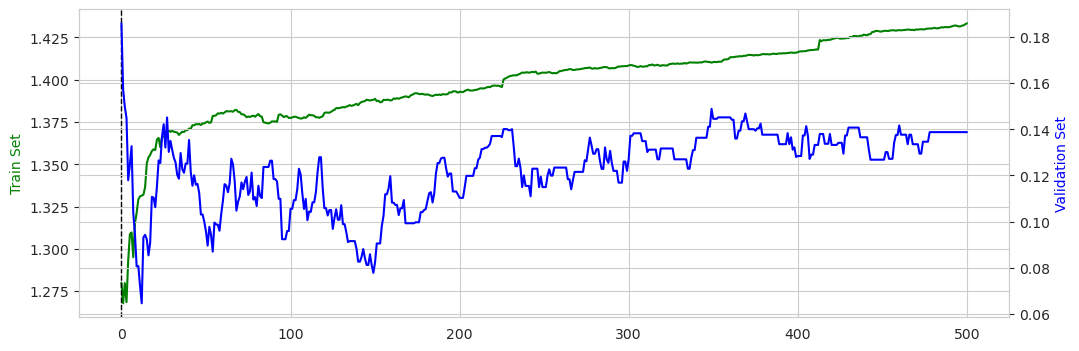

In [12]:
import matplotlib.pyplot as plt

# Create DataFrame from results
cv_result = pd.DataFrame({'Train Set': evals_result['train']['sharpe_ratio'], 
                          'Validation Set': evals_result['valid_0']['sharpe_ratio']})

# Create the plot with separate y-axes for Train and Validation sets
fig, ax1 = plt.subplots(figsize=(12, 4))

ax2 = ax1.twinx()  # instantiate a second axes sharing the same x-axis
ax1.plot(cv_result.index, cv_result['Train Set'], 'g-')
ax2.plot(cv_result.index, cv_result['Validation Set'], 'b-')

ax1.set_ylabel('Train Set', color='g')
ax2.set_ylabel('Validation Set', color='b')
ax1.axvline(cv_result['Validation Set'].idxmax(), c='k', ls='--', lw=1)

plt.show()

In [13]:
best_params = study.best_params
print("Best parameters found by Optuna:")
print(best_params)

Best parameters found by Optuna:
{'num_leaves': 86, 'learning_rate': 0.0024914257978752505, 'feature_fraction': 0.692270523233183, 'bagging_fraction': 0.6520273005825306, 'bagging_freq': 7, 'min_child_samples': 37, 'lambda_l1': 1.9848059472392573e-06, 'lambda_l2': 2.6925006362689277e-06}


In [14]:
lgb_train_all = lgb.Dataset(data=train_data[features], label=train_data[label], 
                            categorical_feature=categoricals, free_raw_data=False)

best_model = lgb.train(params=best_params,
                       train_set=lgb_train_all,
                       num_boost_round=5000,  # or some other number of boosting rounds
                       feval=sharpe_ratio_lgbm,
                       callbacks=[lgb.record_evaluation(evals_result)])

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 95997
[LightGBM] [Info] Number of data points in the train set: 117642, number of used features: 556
[LightGBM] [Info] Start training from score 0.501989


#### Test on unseen data

In [15]:
test_features = test_data[features]
test_labels = test_data[label]

y_pred = best_model.predict(test_features)

preds = test_labels.reset_index(name='actual').assign(predicted=y_pred).set_index(['date', 'ticker'])

# Rename columns to add 'feature_' prefix
cols_to_rename = ['open', 'high', 'low', 'close', 'volume']
new_col_names = ["FEATURE_" + col for col in cols_to_rename]
rename_dict = dict(zip(cols_to_rename, new_col_names))

test_data_renamed = test_data.rename(columns=rename_dict)

# Using the 'merge' method to join on MultiIndex levels 'date' and 'ticker'
preds = preds.reset_index().merge(test_data_renamed[new_col_names].reset_index(), 
                                  on=['ticker', 'date'], 
                                  how='left')

### Only select columns of interest
preds = preds[['date', 'ticker', 'actual', 'predicted'] \
    + new_col_names].set_index(['ticker', 'date'])


In [16]:
preds

actual  predicted  FEATURE_open  FEATURE_high  FEATURE_low  \
ticker date                                                                     
AA     2018-09-24    0.25   0.397240     42.600899     43.274601    41.511799   
       2018-09-25    0.25   0.361032     41.253399     41.541500    40.213902   
       2018-09-26    0.25   0.312567     40.907501     40.907501    39.203400   
       2018-09-27    0.25   0.330050     39.996399     40.421700    39.699200   
       2018-09-28    0.25   0.339807     40.154301     40.961201    39.857101   
...                   ...        ...           ...           ...          ...   
ZTS    2018-10-16    0.75   0.561334     88.508102     89.587799    87.962303   
       2018-10-17    0.75   0.606728     89.423500     90.581902    89.158600   
       2018-10-18    0.75   0.566261     90.094902     90.544098    88.856796   
       2018-10-19    0.75   0.525344     89.356796     90.289200    88.886597   
       2018-10-22    0.75   0.614335     89.365700     90.534103    88.811996   

                   FEATURE_close  FEATURE_volume  
ticker date                                       
AA     2018-09-24      41.561501    4.093206e+06  
       2018-09-25      40.847900    5.201593e+06  
       2018-09-26      40.094700    7.925007e+06  
       2018-09-27      40.114601    2.870088e+06  
       2018-09-28      40.016201    3.791802e+06  
...                          ...             ...  
ZTS    2018-10-16      89.442497    2.399464e+06  
       2018-10-17      90.396698    2.183397e+06  
       2018-10-18      89.462402    1.707729e+06  
       2018-10-19      89.109802    1.781375e+06  
       2018-10-22      90.406601    2.823025e+06  

[5439 rows x 7 columns]

In [17]:
def daily_spearman(group):
    return spearmanr(group['actual'], group['predicted'])[0]

daily_correlations = preds.groupby('date').apply(daily_spearman)

In [18]:
# Calculate the mean and standard deviation of daily correlations
mean_daily_correlation = daily_correlations.mean()
std_daily_correlation = daily_correlations.std()

# Calculate Sharpe ratio for each date
daily_sharpe_ratios = (daily_correlations - mean_daily_correlation) / std_daily_correlation

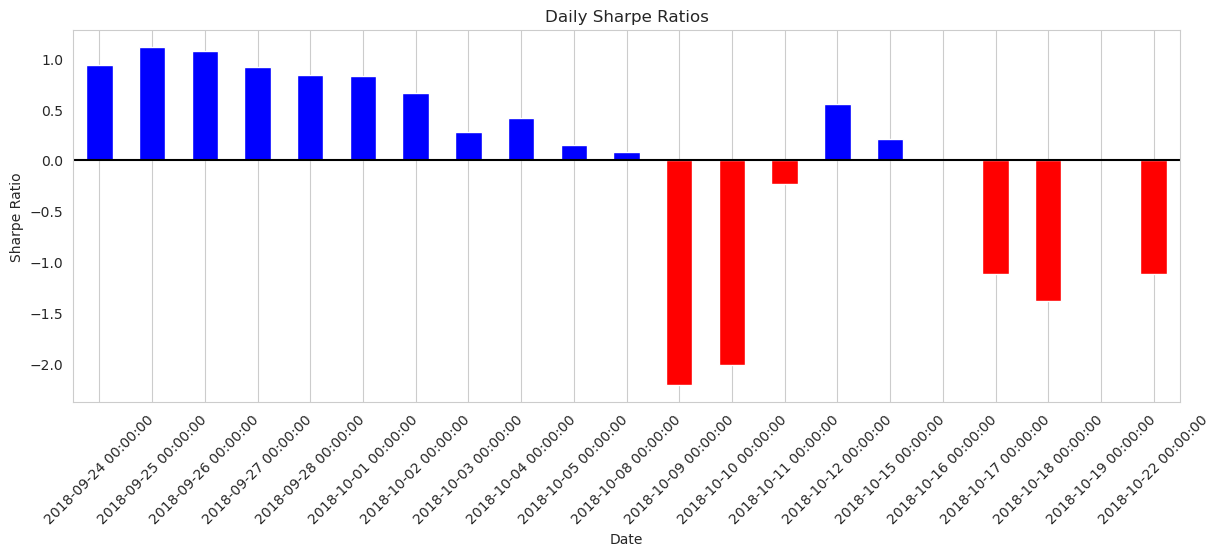

In [19]:
import matplotlib.pyplot as plt

# Create a list of colors based on the sign of the Sharpe Ratios
colors = ['blue' if value > 0 else 'red' for value in daily_sharpe_ratios]

plt.figure(figsize=(12,6))
daily_sharpe_ratios.plot(kind='bar', color=colors)
plt.title('Daily Sharpe Ratios')
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.grid(axis='y')
plt.tight_layout()
plt.axhline(y=0, color='black', linestyle='-')  # Here's where we add the horizontal line at y=0
plt.xticks(rotation=45)  # rotates the x-axis labels for better visibility
plt.show()

In [20]:
lr_r, lr_p = spearmanr(preds.actual, preds.predicted)
print(f'Information Coefficient (overall): {lr_r:.3%} (p-value: {lr_p:.4%})')

Information Coefficient (overall): 93.984% (p-value: 0.0000%)
